Wavenet - language model - autoregressive model

In [57]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [190]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
words = [word.lower() for word in list(words)]
# [p for layer in layers for p in layer.parameters()]
words = [word for word in words if ' ' not in word and '-' not in word] 
print(words[:30])

4945
['aaren', 'aarika', 'abagael', 'abagail', 'abbe', 'abbey', 'abbi', 'abbie', 'abby', 'abbye', 'abigael', 'abigail', 'abigale', 'abra', 'ada', 'adah', 'adaline', 'adan', 'adara', 'adda', 'addi', 'addia', 'addie', 'addy', 'adel', 'adela', 'adelaida', 'adelaide', 'adele', 'adelheid']


In [191]:
# build vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
# chars = [c for c in chars if c not in (' ', '-')]
# print(chars)

stoi = {s:i+1 for i,s in enumerate(chars)}
print(stoi)
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


In [192]:
import random
random.seed(42)
random.shuffle(words)

In [193]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      # if ch not in (' ', '-'):
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

In [194]:
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([27841, 8]) torch.Size([27841])
torch.Size([3515, 8]) torch.Size([3515])
torch.Size([3538, 8]) torch.Size([3538])


In [195]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    # print(x)
    # print(y)
    # for ix in x:
        # print(ix)
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> m
.......m --> a
......ma --> r
.....mar --> t
....mart --> i
...marti --> e
..martie --> .
........ --> j
.......j --> e
......je --> a
.....jea --> n
....jean --> e
...jeane --> t
..jeanet --> t
.jeanett --> e
jeanette --> .
........ --> m
.......m --> i
......mi --> r
.....mir --> e


In [196]:
# https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear

class Linear:
    def __init__(self, in_features, out_features, bias=True):
        self.weight = torch.randn((in_features, out_features)) / in_features**0.5
        self.bias = torch.zeros(out_features) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [197]:
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

In [198]:
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [199]:
torch.manual_seed(42)

In [200]:
n_embd = 10
n_hidden = 200

C = torch.randn(vocab_size, n_embd)

layers = [
    Linear(n_embd * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size), # output
]

with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22519


In [201]:
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] 

    # forward pass
    emb = C[Xb] 
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 00:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/  20000: 3.3785
  10000/  20000: 1.7120


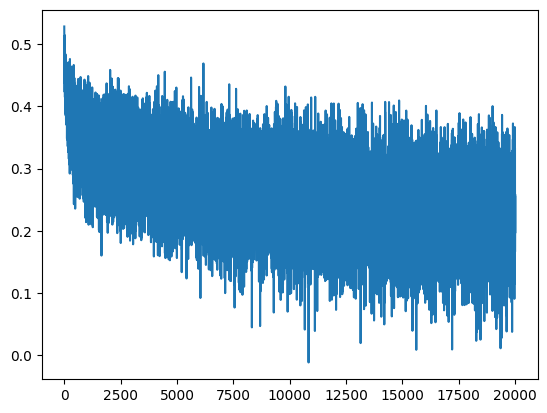

In [202]:
plt.plot(lossi)

In [203]:
for layer in layers:
    layer.training = False

In [210]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.6403613090515137
val 1.949974775314331


In [212]:
# sample from the model
for _ in range(200):
    out = []
    context = [0] * block_size
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)

        # sample for the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        #print(ix)
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        # if we sample '.' break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

sabafarda.
fertanda.
filie.
taolleke.
toli.
elva.
martella.
ashey.
sida.
tarma.
ailee.
devette.
danitia.
avie.
nonzie.
bmedcie.
shelano.
darige.
mila.
margaora.
maryann.
wildette.
bearitte.
marti.
berthe.
lilyttee.
anstanau.
tathetta.
tewty.
cuestea.
deel.
ketette.
hetty.
hetta.
y.
shellet.
towi.
madni.
edi.
detti.
tomi.
elone.
nettye.
katra.
est.
arissa.
rhoba.
doritele.
marla.
suetta.
sabre.
janisha.
vykeet.
sandry.
nitolinn.
viannia.
idetra.
georgeanne.
makolina.
ansabella.
lverta.
bikki.
cherise.
zyn.
maria.
woni.
arda.
geril.
tevwin.
chonstisa.
glendetra.
saria.
nathery.
nonana.
shelene.
ronnissa.
vithie.
jeryn.
zulce.
katharina.
cathee.
vizney.
gaylez.
lotie.
sabryb.
vifab.
delina.
christe.
britnno.
korory.
abbi.
fasda.
shorith.
iona.
kessi.
bibita.
tissce.
diana.
ervana.
malis.
virjana.
nomina.
dianne.
sobi.
dianie.
drista.
barvannah.
marganda.
auglee.
matelixa.
bbethet.
sadeta.
emili.
milge.
hedella.
alico.
devina.
dori.
janita.
betti.
lorieyt.
dety.
pettie.
magti.
baisneita.
v

In [216]:
lossi[:10]

torch.arange(10).view(2,5)
torch.arange(10).view(5,2)
torch.arange(10).view(-1,2)


tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9]])